In [1]:
# SET UP THE ENVIRONMENT

import torch
import numpy as np
import random
import os

def set_all_seeds(seed=42):
    """
    Set all seeds to ensure reproducibility.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# Set seeds before any other code
set_all_seeds(42)

In [2]:
# CREATE DATA CLASSES
from torch.utils.data import Dataset, DataLoader

class InvasionTimeDataset(Dataset):
    def __init__(self, domain_arrays, invasion_arrays):
        """
        Create a dataset for invasion prediction
        
        Parameters:
        - domain_arrays: pore-solid image of shape (N, H, W) where N is number of samples and
          H and W are image height and width. Values of 0 and 1 represent solid and pore pixels.
        - invasion_arrays: CO2 invasion image of shape (N, F, H, W) where F is number of frames
          (invasion timesteps). CO2-invaded pore pixels are 1 and the rest are 0.
        """
        self.domain_arrays = torch.FloatTensor(domain_arrays)
        self.invasion_arrays = torch.FloatTensor(invasion_arrays)
        
        # Add channel dimension to domain arrays
        self.domain_arrays = self.domain_arrays.unsqueeze(1)  # Make (N, 1, H, W)
        
        # Get dimensions
        self.num_sequences = len(domain_arrays) # a sequence includes all timesteps in a single domain
        self.num_frames = invasion_arrays.shape[1]
        self.H, self.W = invasion_arrays.shape[2:]
        
        # Include initial time step in samples_per_sequence
        self.samples_per_sequence = self.num_frames

    def __len__(self):
        return self.num_sequences * self.samples_per_sequence
    
    def __getitem__(self, idx):
        # Calculate which sequence and which time step
        sequence_idx = idx // self.samples_per_sequence # sequence id
        t = idx % self.samples_per_sequence # timestep id within the sequence
        
        # Get domain (constant for the sequence)
        input_domain = self.domain_arrays[sequence_idx]  # Shape: (1, H, W)
        # Get invasion at time t within the sequence
        output_invasion = self.invasion_arrays[sequence_idx, t]  # Shape: (H, W)

        return {
            'input': input_domain,  # Shape: (1, H, W)
            'time': torch.tensor(t, dtype=torch.float),
            'target': output_invasion  # Shape: (H, W)
        }
    
    def get_sequence_start(self, num_samples=1):
        """
        Get the initial data for sequences
        
        Returns:
            dict containing:
            - domain: first num_samples domains (N, 1, H, W)
            - invasion: complete invasion sequences for those domains (N, T, H, W)
        """
        return {
            'input': self.domain_arrays[:num_samples],
            'target': self.invasion_arrays[:num_samples, :, :, :]
        }

def create_sequence_dataloaders(domain_arrays, invasion_arrays, batch_size=32, train_split=0.8):
    """
    Create train, validation, and test dataloaders for sequential prediction
    """
    num_sequences = len(domain_arrays) # a sequence includes all timesteps in a single domain
    num_frames = invasion_arrays.shape[1]
    
    # Calculate split indices
    n_samples = len(domain_arrays)
    n_train = int(n_samples * train_split)
    n_val = n_samples - n_train
    
    # Create random indices
    indices = np.random.permutation(n_samples)
    train_indices = indices[:n_train]
    val_indices = indices[n_train:]
    
    # Create datasets
    train_dataset = InvasionTimeDataset(
        domain_arrays[train_indices],
        invasion_arrays[train_indices]
    )
    
    val_dataset = InvasionTimeDataset(
        domain_arrays[val_indices],
        invasion_arrays[val_indices]
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
        
    return train_loader, val_loader

In [3]:
# CREATE MODEL CLASSES (U-NET WITH RESIDUAL BLOCKS)

import torch
import torch.nn.functional as F
from torch import nn

class ResnetBlock2D(nn.Module):
    def __init__(self, in_channels, out_channels, temb_channels=64, groups=8, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        # Add dropout layers
        self.dropout1 = nn.Dropout2d(dropout)
        self.dropout2 = nn.Dropout2d(dropout)

        # Time embedding projection
        if temb_channels is not None:
            self.time_emb_proj = nn.Linear(temb_channels, out_channels)
        else:
            self.time_emb_proj = None

        # Compute number of groups - ensure it out_channels divides by groups 
        self.groups = min(groups, out_channels)
        while out_channels % self.groups != 0:
            self.groups //= 2
        self.norm1 = nn.GroupNorm(self.groups, out_channels)
        self.norm2 = nn.GroupNorm(self.groups, out_channels)

        # Skip connection with a projection if needed
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, temb=None):
        identity = self.shortcut(x)
        
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.silu(x)  # SiLU activation (also known as Swish)
        x = self.dropout1(x)  # First dropout after activation

        # Add time embedding if provided
        if self.time_emb_proj is not None and temb is not None:
            temb = F.silu(temb)
            temb = self.time_emb_proj(temb)[:, :, None, None]
            x = x + temb

        x = self.conv2(x)
        x = self.norm2(x)
        x = F.silu(x)
        x = self.dropout2(x)  # Second dropout after activation

        return x + identity

class DownBlock2D(nn.Module):
    def __init__(self, in_channels, out_channels, temb_channels=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.resnets = nn.ModuleList([
            ResnetBlock2D(
                in_channels if i == 0 else out_channels,
                out_channels,
                temb_channels=temb_channels,
                dropout=dropout
            ) for i in range(num_layers)
        ])
        self.downsample = nn.Conv2d(out_channels, out_channels, kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(dropout)  # Add dropout after downsampling

    def forward(self, x):
        hidden_states = x
        for resnet in self.resnets:
            hidden_states = resnet(hidden_states)
        downsampled = self.downsample(hidden_states)
        return self.dropout(downsampled), hidden_states

class UpBlock2D(nn.Module):
    def __init__(self, in_channels, out_channels, temb_channels=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.resnets = nn.ModuleList([
            ResnetBlock2D(
                2 * in_channels if i == 0 else out_channels,
                out_channels,
                temb_channels=temb_channels,
                dropout=dropout
            ) for i in range(num_layers)
        ])
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(dropout)

    def forward(self, hidden_states, res_hidden_states, temb=None):
        hidden_states = self.upsample(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = torch.cat([hidden_states, res_hidden_states], dim=1)
        
        for resnet in self.resnets:
            hidden_states = resnet(hidden_states, temb)
        
        return hidden_states

class SimpleUNet(nn.Module):
    def __init__(self, in_channels, out_channels, base_channels=32, time_channels=64, dropout=0.1):
        super().__init__()
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_channels),
            nn.SiLU(),
            nn.Linear(time_channels, time_channels)
        )

        # Initial conv
        self.conv_in = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        
        # Downsampling path
        self.down1 = DownBlock2D(base_channels, base_channels*2, dropout=dropout)
        self.down2 = DownBlock2D(base_channels*2, base_channels*4, dropout=dropout)
        self.down3 = DownBlock2D(base_channels*4, base_channels*8, dropout=dropout)
        
        # Middle
        self.mid_resnet1 = ResnetBlock2D(base_channels*8, base_channels*8, 
                                         temb_channels=time_channels, dropout=2.0*dropout)
        self.mid_resnet2 = ResnetBlock2D(base_channels*8, base_channels*8, 
                                         temb_channels=time_channels, dropout=2.0*dropout)
        
        # Upsampling path
        self.up3 = UpBlock2D(base_channels*8, base_channels*4, 
                             temb_channels=time_channels, dropout=2.0*dropout)
        self.up2 = UpBlock2D(base_channels*4, base_channels*2, 
                             temb_channels=time_channels, dropout=2.0*dropout)
        self.up1 = UpBlock2D(base_channels*2, base_channels, 
                             temb_channels=time_channels, dropout=2.0*dropout)
        
        # Final conv
        self.conv_out = nn.Conv2d(base_channels, out_channels, kernel_size=3, padding=1)
        # self.conv_out = nn.Conv2d(base_channels, 2, kernel_size=3, padding=1)  # Change to 2 channels for the custom loss function

    def forward(self, x, t):
        temb = self.time_mlp(t[:, None])

        # Initial conv
        x = self.conv_in(x)
        
        # Downsampling + skip connections
        down1, skip1 = self.down1(x)
        down2, skip2 = self.down2(down1)
        down3, skip3 = self.down3(down2)
        
        # Middle
        mid = self.mid_resnet1(down3, temb)
        mid = self.mid_resnet2(mid, temb)
        
        # Upsampling + skip connections
        up3 = self.up3(mid, skip3, temb)
        up2 = self.up2(up3, skip2, temb)
        up1 = self.up1(up2, skip1, temb)
        
        # Final conv
        # return F.sigmoid(self.conv_out(up1))
        return self.conv_out(up1)
    
    # When making predictions
    def predict(self, x, t):
        with torch.no_grad():
            output = self.forward(x, t)
            invasion_map = torch.argmax(output, dim=1).float()  # [batch, height, width]
        return invasion_map
        #     probabilities = F.softmax(output, dim=1)
        #     invasion_prob = probabilities[:, 1]  # Take the invasion channel
        # return invasion_prob

In [4]:
# CREATE CUSTOM LOSS CLASSES

class BinaryChannelLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, predictions, targets):
        """
        Custom loss function that handles two-channel predictions with single-channel targets
        
        Args:
            predictions: Model output tensor [batch_size, 2, height, width]
            targets: Target tensor [batch_size, 1, height, width]
            
        Returns:
            loss: Scalar loss value
        """
        # Convert single-channel targets to two channels
        targets_ch0 = 1 - targets  # Background probability
        targets_ch1 = targets      # Invasion probability
        
        # Stack channels to match prediction shape
        targets_2ch = torch.cat([targets_ch0, targets_ch1], dim=1)
        
        # Apply log softmax to predictions
        log_softmax = F.log_softmax(predictions, dim=1)
        
        # Calculate negative log likelihood loss
        loss = -(targets_2ch * log_softmax).sum(dim=1).mean()
        
        return loss
    
class MaskedBinaryChannelLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, predictions, targets, domain_mask):
        """
        Vectorized implementation of per-sample loss normalization
        
        Args:
            predictions: Model output tensor [batch_size, 2, height, width]
            targets: Target tensor [batch_size, 1, height, width]
            domain_mask: Binary mask [batch_size, 1, height, width]
        """
        # Create fluid mask
        fluid_mask = domain_mask.squeeze()  # [batch, height, width]
        
        # Convert single-channel targets to two channels
        targets_ch0 = 1 - targets
        targets_ch1 = targets
        targets_2ch = torch.cat([targets_ch0, targets_ch1], dim=1)
        
        # Apply log softmax to predictions
        log_softmax = F.log_softmax(predictions, dim=1)
        
        # Calculate per-pixel loss
        pixel_loss = -(targets_2ch * log_softmax)  # [batch, 2, height, width]
        pixel_loss = pixel_loss.sum(dim=1)         # [batch, height, width]
        
        # Calculate per-sample loss (vectorized)
        sample_losses = (pixel_loss * fluid_mask).sum(dim=(1, 2))  # Sum over height, width
        valid_pixels = fluid_mask.sum(dim=(1, 2))  # Count valid pixels per sample
        
        # Normalize each sample by its number of valid pixels to avoid differences in pore
        # volumes have an effect
        sample_losses = sample_losses / (valid_pixels + 1e-6)
        
        # Average over batch
        batch_loss = sample_losses.mean()
        
        return batch_loss

In [5]:
# CREATE TRAINING LOOP

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm


def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=25,
    learning_rate=1e-4,
    device='cuda',
    save_path='best_model.pth'
):
    # Initialize model and training components
    model = model.to(device)
    # criterion = nn.MSELoss()
    criterion = MaskedBinaryChannelLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    
    # Track best validation loss
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        # Training loop with progress bar
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch in progress_bar:
            input_domain = batch['input'].to(device)
            input_time = batch['time'].to(device)
            target = batch['target'].to(device).unsqueeze(1)    
                   
            # Forward pass
            optimizer.zero_grad()
            output = model(input_domain, input_time)

            # Calculate loss
            loss = criterion(output, target, input_domain)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            train_batches += 1
            
            # Update progress bar
            progress_bar.set_postfix({'train_loss': f'{train_loss/train_batches:.6f}'})
        
        # Calculate average training loss
        train_loss = train_loss / train_batches
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_domain = batch['input'].to(device)
                input_time = batch['time'].to(device)
                target = batch['target'].to(device).unsqueeze(1)
                
                output = model(input_domain, input_time)
                
                loss = criterion(output, target, input_domain)
                
                val_loss += loss.item()
                val_batches += 1
        
        # Calculate average validation loss
        val_loss = val_loss / val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.6f}')
        print(f'Val Loss: {val_loss:.6f}')
        print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'best_val_loss': best_val_loss
            }, save_path)
            print(f'Saved new best model with validation loss: {val_loss:.6f}')
        
        print('-' * 50)
        
    return model

In [6]:
# CREATE DATALOADERS FOR TRAINING

# Paths to the save data arrays 
domain_path = "./data/reduced_domain_arrays.npy"
invasion_path = "./data/reduced_invasion_arrays.npy"

# Load the reduced (25 timesteps) domain data
domain_arrays = np.load(domain_path, mmap_mode='r')
print(f"Domain shape: {domain_arrays.shape}")

# Load the invasion data
invasion_arrays = np.load(invasion_path, mmap_mode='r')
print(f"Invasion shape: {invasion_arrays.shape}")

# Create dataloaders
train_loader, val_loader = create_sequence_dataloaders(
    domain_arrays,
    invasion_arrays,
    batch_size=16,
    train_split=0.8,
)

Domain shape: (142, 512, 128)
Invasion shape: (142, 25, 512, 128)


In [8]:
# CREATE, SUMMARISE AND VISUALISE THE MODEL
# Note: requires torchinfo and torchviz to be installed
import torchinfo

# Create an instance of the model
model = SimpleUNet(in_channels=1, out_channels=2, # out_channels=2 is for compatibility with MaskedBinaryChannelLoss
                   base_channels=16, time_channels=64, 
                   dropout=0.3)
# Print a model summary
torchinfo.summary(model = model,
                  input_size = [(1, 1, 512, 128), (1,)],
                  col_names = ["input_size", "output_size", "num_params", "trainable"],
                  col_width = 20,
                  depth = 5,
                  row_settings = ["var_names"],
                  verbose = 0,
                  device = 'cpu')

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
SimpleUNet (SimpleUNet)                       [1, 1, 512, 128]     [1, 2, 512, 128]     --                   True
├─Sequential (time_mlp)                       [1, 1]               [1, 64]              --                   True
│    └─Linear (0)                             [1, 1]               [1, 64]              128                  True
│    └─SiLU (1)                               [1, 64]              [1, 64]              --                   --
│    └─Linear (2)                             [1, 64]              [1, 64]              4,160                True
├─Conv2d (conv_in)                            [1, 1, 512, 128]     [1, 16, 512, 128]    160                  True
├─DownBlock2D (down1)                         [1, 16, 512, 128]    [1, 32, 256, 64]     --                   True
│    └─ModuleList (resnets)                   --                   --                

In [9]:
# TRAIN THE MODEL

# Prioritise GPU
device_num = 1
# device = torch.device(f'cuda:{device_num}' if torch.cuda.is_available() else 'cpu')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

runtype = 'time_class'
run_training = True

if run_training:
    # Train model
    trained_model = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=8,
        learning_rate=1e-4,
        device=device,
        save_path=f'best_model_{runtype}.pth'
    )

Epoch 1/8: 100%|██████████| 177/177 [00:24<00:00,  7.25it/s, train_loss=0.480414]


Epoch 1/8:
Train Loss: 0.480414
Val Loss: 0.274403
Learning Rate: 0.000096
Saved new best model with validation loss: 0.274403
--------------------------------------------------


Epoch 2/8: 100%|██████████| 177/177 [00:24<00:00,  7.26it/s, train_loss=0.284750]


Epoch 2/8:
Train Loss: 0.284750
Val Loss: 0.249776
Learning Rate: 0.000086
Saved new best model with validation loss: 0.249776
--------------------------------------------------


Epoch 3/8: 100%|██████████| 177/177 [00:24<00:00,  7.29it/s, train_loss=0.266945]


Epoch 3/8:
Train Loss: 0.266945
Val Loss: 0.238726
Learning Rate: 0.000069
Saved new best model with validation loss: 0.238726
--------------------------------------------------


Epoch 4/8: 100%|██████████| 177/177 [00:24<00:00,  7.24it/s, train_loss=0.254336]


Epoch 4/8:
Train Loss: 0.254336
Val Loss: 0.232933
Learning Rate: 0.000051
Saved new best model with validation loss: 0.232933
--------------------------------------------------


Epoch 5/8: 100%|██████████| 177/177 [00:24<00:00,  7.27it/s, train_loss=0.247177]


Epoch 5/8:
Train Loss: 0.247177
Val Loss: 0.227887
Learning Rate: 0.000032
Saved new best model with validation loss: 0.227887
--------------------------------------------------


Epoch 6/8: 100%|██████████| 177/177 [00:24<00:00,  7.26it/s, train_loss=0.242192]


Epoch 6/8:
Train Loss: 0.242192
Val Loss: 0.225568
Learning Rate: 0.000015
Saved new best model with validation loss: 0.225568
--------------------------------------------------


Epoch 7/8: 100%|██████████| 177/177 [00:24<00:00,  7.11it/s, train_loss=0.239004]


Epoch 7/8:
Train Loss: 0.239004
Val Loss: 0.227666
Learning Rate: 0.000005
--------------------------------------------------


Epoch 8/8: 100%|██████████| 177/177 [00:24<00:00,  7.24it/s, train_loss=0.237740]


Epoch 8/8:
Train Loss: 0.237740
Val Loss: 0.225404
Learning Rate: 0.000001
Saved new best model with validation loss: 0.225404
--------------------------------------------------


In [10]:
# CREATE FUNCTION TO COMPARE TARGETS AND PREDICTIONS

import matplotlib.pyplot as plt

def plot_comparison(model, dataloader, num_samples=3, device='cuda', save_path=None, eval_str=None):
    """
    Plot comparison between predicted and true invasion fields
    
    Args:
        model: trained model
        dataloader: training or validation dataloader
        num_samples: number of samples to plot
        device: device to run model on
        save_path: optional path to save figure
    """
    model.eval()
    
    # Get samples
    # Get initial sequences
    initial_data = dataloader.dataset.get_sequence_start(num_samples)
    input_domain = initial_data['input'].to(device)
    true_invasion = initial_data['target'].cpu()
    
    # Generate sequential predictions
    pred_invasion = torch.zeros_like(true_invasion)
    with torch.no_grad():
        for t in range(true_invasion.shape[1]):
            input_time = torch.tensor([t], dtype=torch.float).to(device)
            pred_invasion[:, t] = \
                model.predict(input_domain, input_time).cpu().squeeze()
    # Note: it would also be possible to make batch predictions. The above
    # is also compatible with sequence models and autoregressive methods. 
    
    # Create figure
    fig, axes = plt.subplots(num_samples, 7, figsize=(10, 3.5*num_samples))
    plt.subplots_adjust(hspace=0.3)
    
    for idx in range(num_samples):
        # Plot domain
        axes[idx, 0].imshow(1-input_domain[idx, 0].cpu(), cmap='Blues')
        axes[idx, 0].set_title(f'Sample {idx+1}\nDomain')
        axes[idx, 0].axis('off')
        
        # Plot first, middle and last frames for both true and predicted
        frames = [0, 12, -1]  # First, middle, last
        for i, frame in enumerate(frames):
            # True invasion
            axes[idx, i+1].imshow(true_invasion[idx, frame], cmap='YlOrRd')
            axes[idx, i+1].set_title(f'True\nFrame {frame}')
            axes[idx, i+1].axis('off')
            pred_invasion[idx, frame]

            # Predicted invasion
            axes[idx, i+4].imshow(
                (pred_invasion[idx, frame] > 0.5) * input_domain[idx, 0].cpu(),
                cmap='YlOrRd')
            axes[idx, i+4].set_title(f'Predicted\nFrame {frame}')
            axes[idx, i+4].axis('off')
    
    plt.suptitle(f'True vs Predicted Invasion Fields{eval_str}', y=1.02, fontsize=16)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

Loaded model from epoch: 7
Best validation loss: 0.22540394994227783


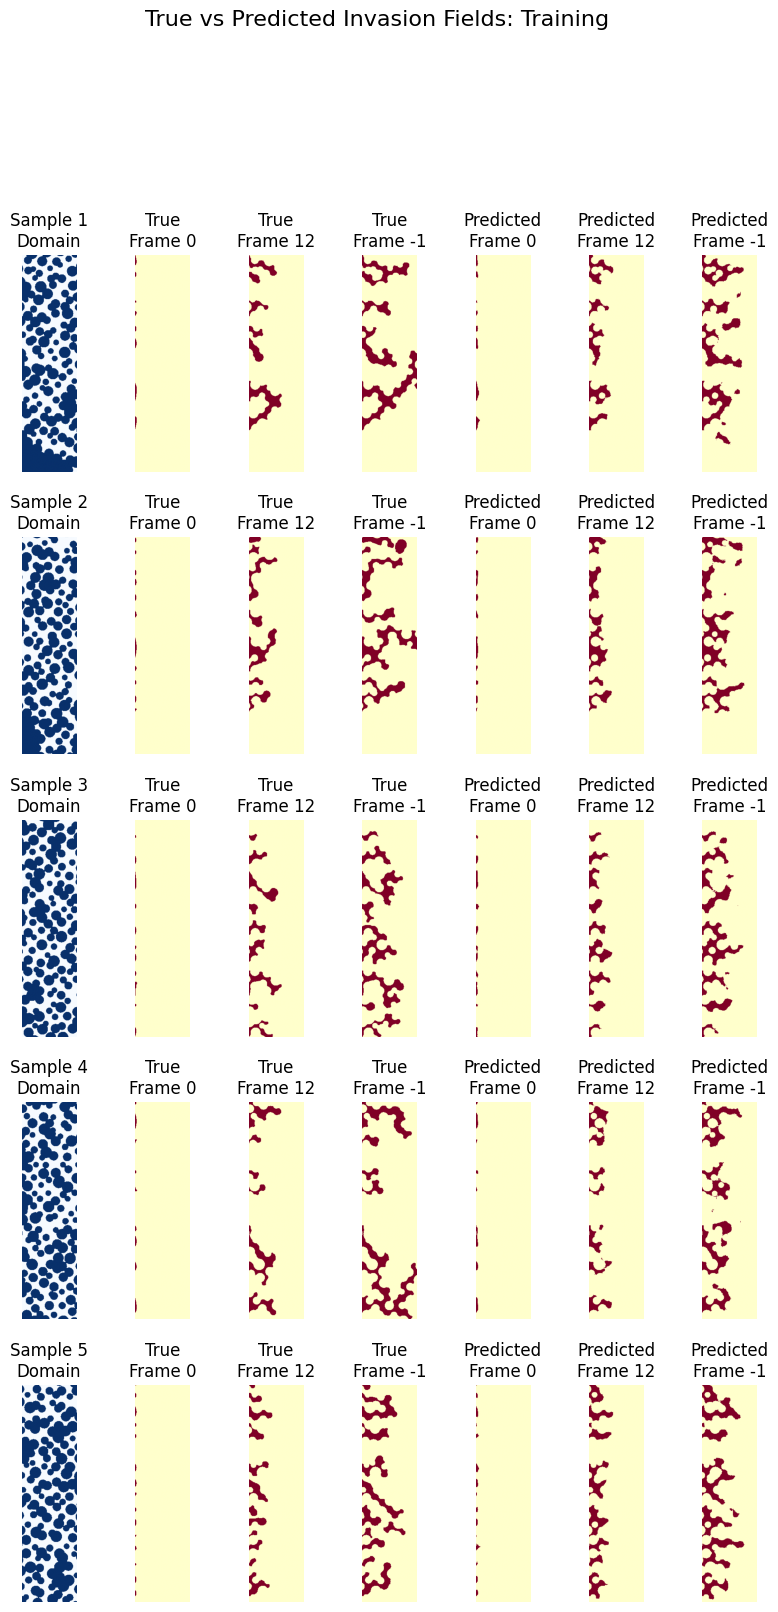

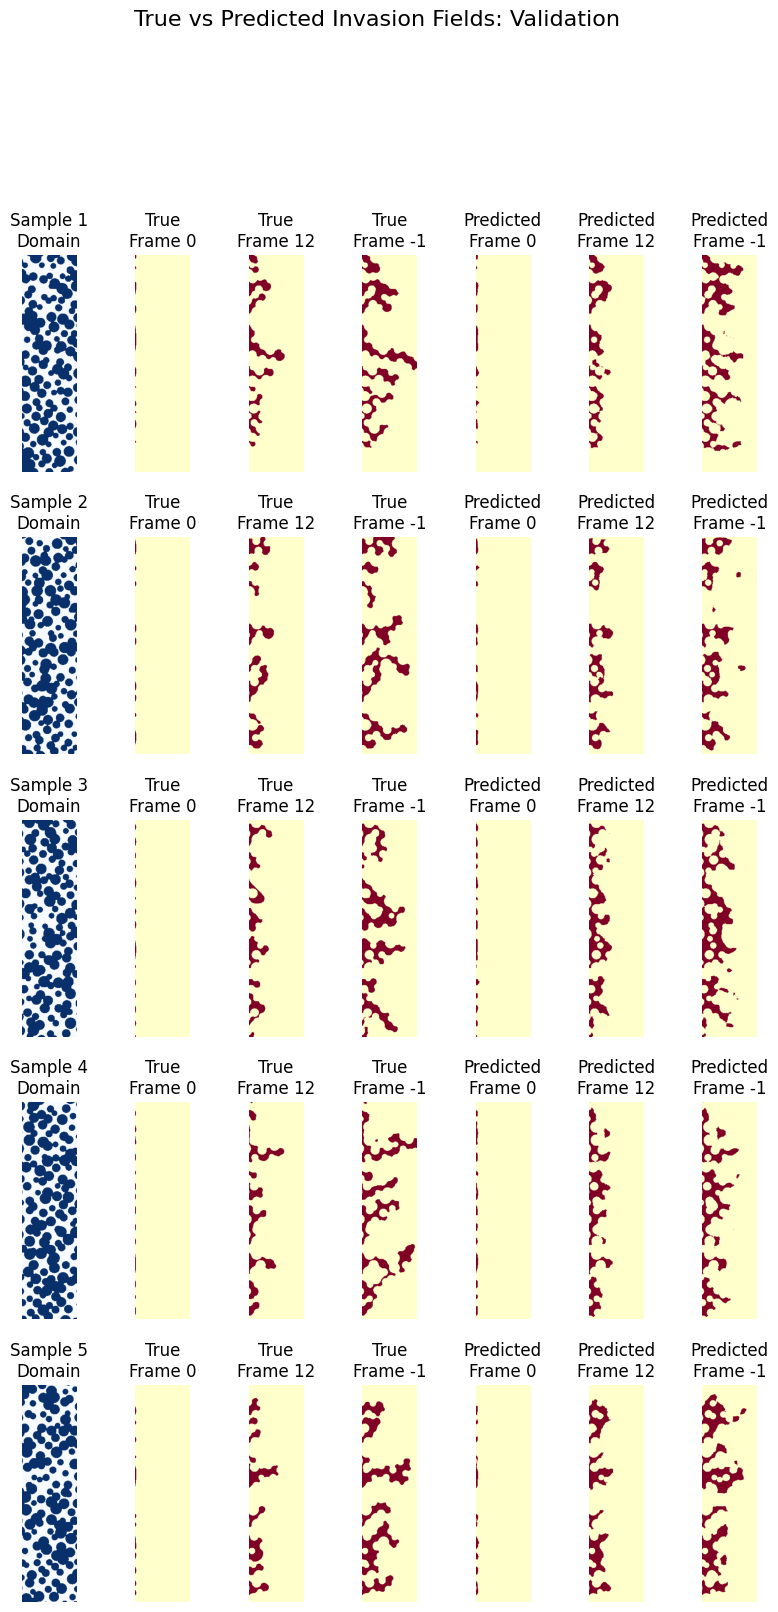

In [11]:
# COMPARE TARGETS AND PREDICTIONS

# Load the best weights into the model
checkpoint = torch.load(f'best_model_{runtype}.pth')
model = SimpleUNet(in_channels=1, out_channels=2, base_channels=16, time_channels=64)  # Create model instance
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()  # Set to evaluation mode

# Print some info about the loaded checkpoint
print(f"Loaded model from epoch: {checkpoint['epoch']}")
print(f"Best validation loss: {checkpoint['best_val_loss']}")

# Visualize predictions
plot_comparison(model, train_loader, num_samples=5, device=device, 
                save_path=f'train_comparison_{runtype}.pdf', eval_str=': Training')
plot_comparison(model, val_loader, num_samples=5, device=device, 
                save_path=f'val_comparison_{runtype}.pdf',  eval_str=': Validation')

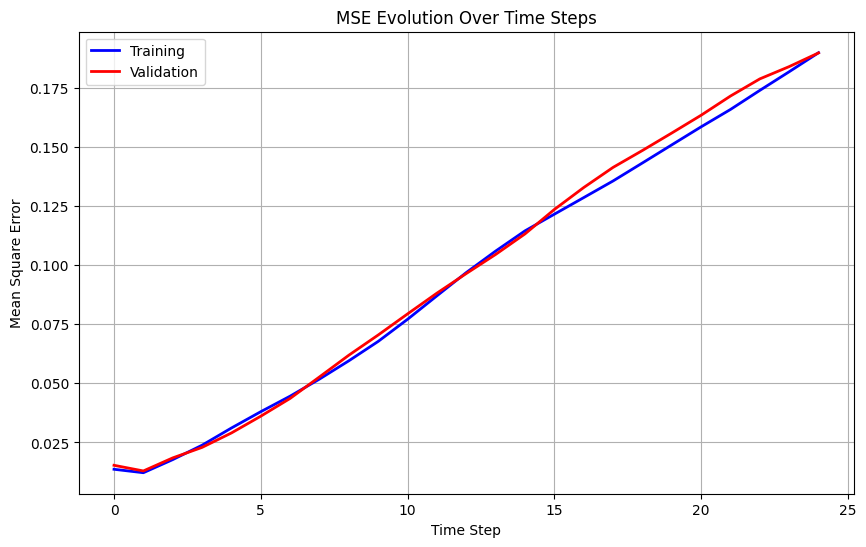

Average Train MSE: 0.095701
Average Val MSE: 0.097437
Final Time Step Train MSE: 0.189979
Final Time Step Val MSE: 0.189900


In [12]:
class MaskedMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, predictions, targets, domain_mask):
        """
        Calculate MSE only in fluid regions, first averaging per sample then over batch
        
        Args:
            predictions: Model predictions [batch, height, width]
            targets: Target values [batch, height, width]
            domain_mask: Binary mask [batch, 1, height, width] where:
                        0 = solid (ignore)
                        1 = pore space (compute MSE)
        """
        # Create fluid mask
        fluid_mask = domain_mask.squeeze(1)  # Remove channel dim to match predictions
        
        # Calculate squared error
        # squared_error = (predictions - targets.squeeze(1))**2
        squared_error = (predictions - targets)**2
        
        # Calculate per-sample MSE
        sample_mse = (squared_error * fluid_mask).sum(dim=(1, 2)) / (fluid_mask.sum(dim=(1, 2)) + 1e-6)
        
        # Average over batch
        batch_mse = sample_mse.mean()
        return batch_mse

def plot_sequential_mse_over_time(model, train_dataset, val_dataset, device, save_path=None):
    model.eval()
    # criterion = nn.MSELoss(reduction='none')
    criterion = MaskedMSELoss()

    def calculate_sequential_mse(dataset):
        num_sequences = len(dataset.domain_arrays)
        num_timesteps = dataset.invasion_arrays.shape[1]
        all_mse = torch.zeros(num_sequences, num_timesteps)
        
        with torch.no_grad():
            for seq_idx in range(num_sequences):
                # Get initial sequence data
                input_domain = dataset.domain_arrays[seq_idx:seq_idx+1].to(device)
                true_invasion = dataset.invasion_arrays[seq_idx:seq_idx+1].to(device)
                                
                # Sequential prediction and error calculation
                for t in range(num_timesteps):
                    # Prepare input
                    input_time = torch.tensor([t], dtype=torch.float).to(device)
                    # Get prediction
                    next_invasion = model.predict(input_domain, input_time).squeeze(1)
                    # Calculate MSE for this timestep
                    mse = criterion(next_invasion, true_invasion[:, t], input_domain)
                    all_mse[seq_idx, t] = mse.mean().cpu()  # Average over spatial dimensions
                    
        # Average over sequences
        return all_mse.mean(dim=0)
    
    # Calculate MSE for both datasets
    train_mse = calculate_sequential_mse(train_dataset)
    val_mse = calculate_sequential_mse(val_dataset)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    time_steps = range(len(train_mse))
    
    plt.plot(time_steps, train_mse, 'b-', label='Training', linewidth=2)
    plt.plot(time_steps, val_mse, 'r-', label='Validation', linewidth=2)
    
    plt.xlabel('Time Step')
    plt.ylabel('Mean Square Error')
    plt.title('MSE Evolution Over Time Steps')
    plt.legend()
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    
    # Print statistics
    print(f"Average Train MSE: {train_mse.mean():.6f}")
    print(f"Average Val MSE: {val_mse.mean():.6f}")
    print(f"Final Time Step Train MSE: {train_mse[-1]:.6f}")
    print(f"Final Time Step Val MSE: {val_mse[-1]:.6f}")
    
    return train_mse, val_mse

# Usage
train_mse, val_mse = plot_sequential_mse_over_time(
    model, 
    train_loader.dataset,  # Note: using dataset instead of loader
    val_loader.dataset, 
    device=device, 
    save_path=f'sequential_mse_over_time_{runtype}.pdf'
)